In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import os

DATASET_PATH = "/content/drive/MyDrive/project_dataset"
print("Dataset Path:", DATASET_PATH)


Dataset Path: /content/drive/MyDrive/project_dataset


In [5]:
import numpy as np
import cv2

IMG_SIZE = 128

def load_stage1_dataset(dataset_path, limit=None):

    images = []
    masks = []

    folders = os.listdir(dataset_path)
    if limit:
        folders = folders[:limit]

    for folder in folders:

        folder_path = os.path.join(dataset_path, folder)

        img_folder = os.path.join(folder_path, "images")
        mask_folder = os.path.join(folder_path, "masks")

        if not os.path.exists(img_folder):
            continue

        # Load Image
        img_file = os.listdir(img_folder)[0]
        img_path = os.path.join(img_folder, img_file)

        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        # Merge Masks
        merged_mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)

        for mask_file in os.listdir(mask_folder):
            mask_path = os.path.join(mask_folder, mask_file)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
            mask = mask / 255.0

            merged_mask += mask

        merged_mask = (merged_mask > 0).astype("float32")
        merged_mask = np.expand_dims(merged_mask, axis=-1)

        images.append(img)
        masks.append(merged_mask)

    return np.array(images), np.array(masks)


In [6]:
X = np.load("/content/drive/MyDrive/X.npy")
Y = np.load("/content/drive/MyDrive/Y.npy")

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def residual_block(x, filters):

    shortcut = layers.Conv2D(filters, 1, padding="same")(x)

    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)

    x = layers.Add()([shortcut, x])
    return x


In [9]:
def attention_gate(x, g, filters):

    theta_x = layers.Conv2D(filters, 1, padding="same")(x)
    phi_g = layers.Conv2D(filters, 1, padding="same")(g)

    add = layers.Add()([theta_x, phi_g])
    act = layers.Activation("relu")(add)

    psi = layers.Conv2D(1, 1, activation="sigmoid")(act)

    return layers.Multiply()([x, psi])


In [10]:
def aspp(x, filters):

    conv1 = layers.Conv2D(filters, 1, activation="relu", padding="same")(x)

    conv6 = layers.Conv2D(filters, 3, dilation_rate=6,
                          activation="relu", padding="same")(x)

    conv12 = layers.Conv2D(filters, 3, dilation_rate=12,
                           activation="relu", padding="same")(x)

    conv18 = layers.Conv2D(filters, 3, dilation_rate=18,
                           activation="relu", padding="same")(x)

    x = layers.Concatenate()([conv1, conv6, conv12, conv18])
    x = layers.Conv2D(filters, 1, activation="relu", padding="same")(x)

    return x


In [11]:
def ResUNetPP(input_shape=(128,128,3)):

    inputs = layers.Input(input_shape)

    # Encoder
    c1 = residual_block(inputs, 32)
    p1 = layers.MaxPooling2D()(c1)

    c2 = residual_block(p1, 64)
    p2 = layers.MaxPooling2D()(c2)

    c3 = residual_block(p2, 128)
    p3 = layers.MaxPooling2D()(c3)

    c4 = residual_block(p3, 256)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck with ASPP
    b1 = aspp(p4, 512)

    # Decoder + Attention
    u1 = layers.UpSampling2D()(b1)
    att1 = attention_gate(c4, u1, 256)
    u1 = layers.Concatenate()([u1, att1])
    d1 = residual_block(u1, 256)

    u2 = layers.UpSampling2D()(d1)
    att2 = attention_gate(c3, u2, 128)
    u2 = layers.Concatenate()([u2, att2])
    d2 = residual_block(u2, 128)

    u3 = layers.UpSampling2D()(d2)
    att3 = attention_gate(c2, u3, 64)
    u3 = layers.Concatenate()([u3, att3])
    d3 = residual_block(u3, 64)

    u4 = layers.UpSampling2D()(d3)
    att4 = attention_gate(c1, u4, 32)
    u4 = layers.Concatenate()([u4, att4])
    d4 = residual_block(u4, 32)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(d4)

    return Model(inputs, outputs)


In [12]:
model = ResUNetPP()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        128 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ conv2d[0][0],     │
│                     │ 32)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ conv2d_3[0][0],   │
│                     │ 64)               │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ add_1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │      8,320 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 32, 32,    │          0 │ conv2d_6[0][0],   │
│                     │ 128)              │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ add_2[0][0]       │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[

 Total params: 9,595,589 (36.60 MB)

 Trainable params: 9,595,589 (36.60 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [14]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=10,
    batch_size=4
)


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 324s 8s/step - accuracy: 0.8205 - loss: 0.6927 - val_accuracy: 0.8229 - val_loss: 0.6558
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 302s 8s/step - accuracy: 0.8636 - loss: 0.3130 - val_accuracy: 0.9348 - val_loss: 0.1851
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 308s 8s/step - accuracy: 0.9225 - loss: 0.1954 - val_accuracy: 0.9474 - val_loss: 0.1334
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 305s 8s/step - accuracy: 0.9416 - loss: 0.1481 - val_accuracy: 0.9055 - val_loss: 0.2130
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 306s 8s/step - accuracy: 0.9471 - loss: 0.1382 - val_accuracy: 0.9550 - val_loss: 0.1200
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 306s 8s/step - accuracy: 0.9593 - loss: 0.1063 - val_accuracy: 0.9557 - val_loss: 0.1228
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 322s 8s/step - accuracy: 0.9697 - loss: 0.0815 - val_accuracy: 0.9593 - val_loss: 0.1088
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 324s 8s/step - accuracy: 0.9615 - loss: 0.0984 - val_accuracy: 0.9544 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


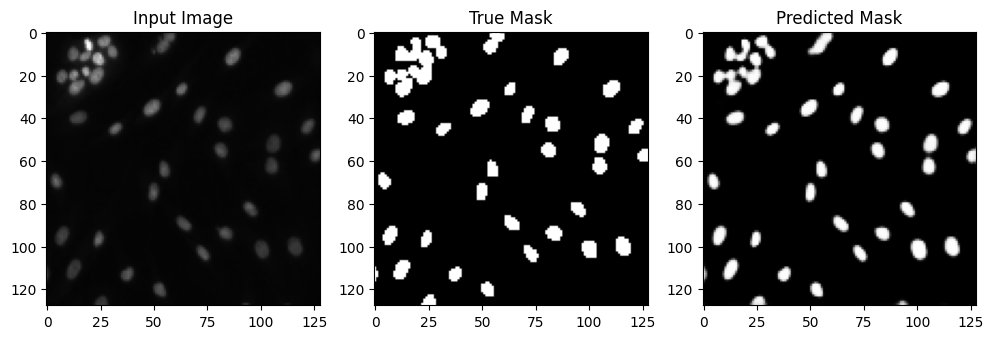

In [15]:
import matplotlib.pyplot as plt

index = 0
pred = model.predict(X_test[index:index+1])[0]

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(X_test[index])

plt.subplot(1,3,2)
plt.title("True Mask")
plt.imshow(Y_test[index].squeeze(), cmap="gray")

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred.squeeze(), cmap="gray")

plt.show()


In [16]:
model.save("/content/drive/MyDrive/resunetpp_model.h5")
print("ResUNet++ Model Saved Successfully!")

ResUNet++ Model Saved Successfully!
